In [1]:
#required packages


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader

import numpy as np
import matplotlib.pyplot as plt



In [2]:
# Downloading MNIST dataset from pytorch

train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True

    #Applying transform i.e. converting image to tensor
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



 labe1 is :  5


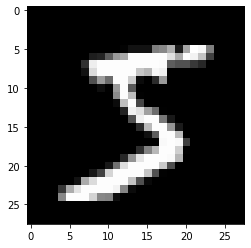

In [3]:
#Data visualizations

img, label  = next(iter(train_set))
plt.imshow(img.squeeze(0),cmap = "gray")
print( f' labe1 is : ', label)

In [4]:
# Preparing Dataset

class Dataset_Mnist(Dataset):
  def __init__(self):
    self.data = train_set
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    #generating random number using torch.randint() function

    rand_input =torch.randint(low=0,high=10, size = (1,))
    
    # Getting image and label from MNIST data
    image, img_label = self.data[index]

    # Calculating label using sum of image label and random number generated
    sum_label = img_label + rand_input

    # Returning Two inputs and Two labels for Training
    return {"inputs" : [image, rand_input],"labels" : [img_label, sum_label]}


In [5]:

# Creating instance of Dataset_Mnist class

modified_mnist = Dataset_Mnist()
output = modified_mnist.__getitem__(2)
output["labels"]

[4, tensor([5])]

In [6]:
#writing a dataloader for plotting
loader = DataLoader(modified_mnist,batch_size = 32,shuffle = True,drop_last=True)

Shape of images: torch.Size([32, 1, 28, 28]) 

random_numbers are :  tensor([0, 1, 0, 7, 7, 3, 4, 4, 3, 4, 5, 6, 9, 8, 0, 7, 0, 0, 8, 0, 1, 5, 7, 4,
        7, 8, 6, 1, 9, 8, 0, 1])

 image labels are: tensor([7, 5, 3, 8, 0, 2, 4, 0, 2, 8, 8, 6, 4, 7, 8, 1, 3, 7, 3, 9, 4, 8, 7, 3,
        4, 3, 3, 9, 1, 7, 2, 6]) 

 sum labels are : tensor([ 7,  6,  3, 15,  7,  5,  8,  4,  5, 12, 13, 12, 13, 15,  8,  8,  3,  7,
        11,  9,  5, 13, 14,  7, 11, 11,  9, 10, 10, 15,  2,  7])




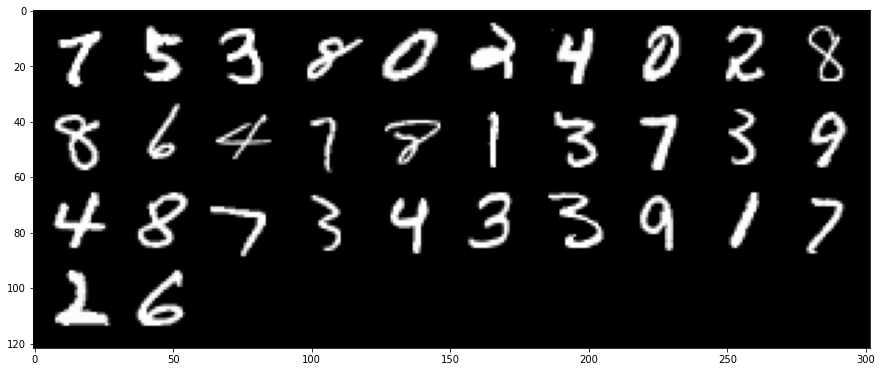

In [9]:
#plotting a batch of data from  dataloader 

for batch in loader :
  
  inputs, labels = batch.values()
  img_labels, sum_labels = labels
  images,rand_inputs = inputs

  grid = torchvision.utils.make_grid(images, nrow=10)
  plt.figure(figsize = (15,15))
  plt.imshow(np.transpose(grid,(1,2,0)))

  print(f"Shape of images: {images.shape} \n")
  print("random_numbers are : ",inputs[1].squeeze(1))
  print(f'\n image labels are: {img_labels} \n\n sum labels are : {sum_labels.squeeze(1)}\n\n')

  break


In [ ]:

# Defining Batch size
batch_size = 120

# Creating Data Loader for training

train_loader = DataLoader(modified_mnist,batch_size = batch_size,shuffle = True,drop_last=True)

In [ ]:
# Network architecture 

#1. Flatten image (28 * 28 --> 784) and concatenate with random number (one hot encoded) 

#   Concatenated input size : 784 + 10 = 794

#   Pass concatenated data through feed forward NN ( With Relu activation ) (Not used any CNNs)

#   use output from self.fc2 to get out1 and out2 

#   self.fc2 -->  self.fc1_out1  --> self.fc2_out1 --> out1

#   self.fc2 -->  self.fc1_out2  --> out2

#   Return out1 and out2

class Mnist_ff(nn.Module):
  def __init__(self):
    super().__init__()
  
    #input = 28*28 + 10  output  = 128 
    self.fc1 = nn.Linear(in_features  = 28*28 + 10 , out_features = 128)
    self.fc2 = nn.Linear(in_features = 128, out_features = 64)
    self.relu = F.relu
    self.fc1_out1 = nn.Linear(in_features = 64, out_features = 32)
    self.fc2_out1 = nn.Linear(in_features= 32, out_features = 10)
    self.fc1_out2 = nn.Linear(in_features = 64, out_features = 19)


  def forward(self,x, randnum ):
    x, randnum = x.reshape(batch_size,-1), randnum.reshape(batch_size,-1)
    x = torch.cat((x,randnum),dim=1 )
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))

    out1 = self.fc2_out1(self.relu(self.fc1_out1(x)))
    out2 = self.fc1_out2(x)

    return out1,out2




In [ ]:
# Creating instance of Mnist_ff()

model = Mnist_ff()

# Model architecture

print(model)


Mnist_ff(
  (fc1): Linear(in_features=794, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc1_out1): Linear(in_features=64, out_features=32, bias=True)
  (fc2_out1): Linear(in_features=32, out_features=10, bias=True)
  (fc1_out2): Linear(in_features=64, out_features=19, bias=True)
)


In [ ]:
#Trained on CPU


# Using Adad Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)


for epoch in range(50):
  total_loss = 0  

  for batch in train_loader:
    inputs, labels = batch.values()
    
    img_labels, sum_labels = labels
    img_labels, sum_labels = F.one_hot(img_labels, num_classes = 10), F.one_hot(sum_labels, num_classes = 19).squeeze(1)
    images,rand_inputs = inputs
    rand_inputs = F.one_hot(rand_inputs, num_classes = 10)
    
    out1, out2 = model(images,rand_inputs)

    # Using Cross Entropy because we have multiple classes as outputs

    # Total loss = loss from image detection + loss from summation prediction

    loss1 = F.cross_entropy(out1, img_labels.float())

    loss2 =  F.cross_entropy(out2, sum_labels.float())
    
    loss = loss1 + loss2

    #Zeroing out gradients to prevent accumulation in next iteration
    optimizer.zero_grad()

    #calculating gradients
    loss.backward()

    #gradient update
    optimizer.step()

    total_loss += loss

    
  print(f"loss at epoch: {epoch}  is  {total_loss.item()}")
  



loss at epoch: 0  is  821.527099609375
loss at epoch: 1  is  227.16062927246094
loss at epoch: 2  is  162.1258087158203
loss at epoch: 3  is  143.1830291748047
loss at epoch: 4  is  126.12157440185547
loss at epoch: 5  is  120.95542907714844
loss at epoch: 6  is  114.85391998291016
loss at epoch: 7  is  102.51146697998047
loss at epoch: 8  is  102.35953521728516
loss at epoch: 9  is  99.97547912597656
loss at epoch: 10  is  91.51361083984375
loss at epoch: 11  is  92.4646987915039
loss at epoch: 12  is  90.44698333740234
loss at epoch: 13  is  86.82398986816406
loss at epoch: 14  is  79.69280242919922
loss at epoch: 15  is  78.66291046142578
loss at epoch: 16  is  78.4300308227539
loss at epoch: 17  is  80.95767211914062
loss at epoch: 18  is  78.66265869140625
loss at epoch: 19  is  71.2935562133789
loss at epoch: 20  is  69.60258483886719
loss at epoch: 21  is  72.84759521484375
loss at epoch: 22  is  64.9349365234375
loss at epoch: 23  is  70.33512878417969
loss at epoch: 24  is  62

In [ ]:
#predictions after training model for 50 iterations

acc1,acc2 = 0,0

for batch in train_loader:
    inputs, labels = batch.values()
    
    img_labels, sum_labels = labels
    images,rand_inputs = inputs
    
    rand_inputs = F.one_hot(rand_inputs, num_classes = 10)
    out1, out2 = model(images,rand_inputs)

    preds1 = torch.argmax(out1,dim = 1)
    preds2 = torch.argmax(out2,dim=1)

    acc1 += (preds1 == img_labels).sum()
    acc2 += (preds2 == sum_labels.squeeze(1)).sum()
    
print(f"images correctly predicted are : {acc1} \n correctly predicted sums are :   {acc2}")
  

images correctly predicted are : 5773 
 correctly predicted sums are :   5339


In [ ]:
#Trained on GPU

# Checking whether GPU is available or not
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f"currently using : {device}")

train_loader_gpu = DataLoader(modified_mnist, batch_size=batch_size, shuffle = True, pin_memory = True, num_workers=1 )

#loading model to GPU 
model = Mnist_ff().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(50):
  total_loss = 0  

  for batch in train_loader:
    inputs, labels = batch.values()
    
    img_labels, sum_labels = labels

    #loading inputs and labels to GPU
    img_labels, sum_labels = F.one_hot(img_labels, num_classes = 10).to(device), F.one_hot(sum_labels, num_classes = 19).squeeze(1).to(device)
    images,rand_inputs = inputs
    rand_inputs = F.one_hot(rand_inputs, num_classes = 10).to(device)

    out1, out2 = model(images.to(device),rand_inputs)
    
    loss = F.cross_entropy(out1, img_labels.float())+F.cross_entropy(out2, sum_labels.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss
    
    
  print(f"loss at epoch: {epoch}  is  {total_loss.item()}")
  

currently using : cuda
loss at epoch: 0  is  831.6533203125
loss at epoch: 1  is  213.44900512695312
loss at epoch: 2  is  162.30429077148438
loss at epoch: 3  is  146.4093017578125
loss at epoch: 4  is  131.2504425048828
loss at epoch: 5  is  117.83135223388672
loss at epoch: 6  is  109.9270248413086
loss at epoch: 7  is  110.06220245361328
loss at epoch: 8  is  107.97510528564453
loss at epoch: 9  is  98.94684600830078
loss at epoch: 10  is  97.65160369873047
loss at epoch: 11  is  92.60734558105469
loss at epoch: 12  is  84.51805114746094
loss at epoch: 13  is  79.87027740478516
loss at epoch: 14  is  78.74300384521484
loss at epoch: 15  is  80.49381256103516
loss at epoch: 16  is  78.53385162353516
loss at epoch: 17  is  80.85194396972656
loss at epoch: 18  is  73.24776458740234
loss at epoch: 19  is  66.44271087646484
loss at epoch: 20  is  68.78443908691406
loss at epoch: 21  is  68.30306243896484
loss at epoch: 22  is  71.2000732421875
loss at epoch: 23  is  71.27172088623047
lo

In [ ]:
# #building architecture
# class Mnist_Network(nn.Module):
#   def __init__(self):
#     super().__init__()

#     # input 28 # output 24 # receptive_field = 5*5
#     self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
#     # input 24 # output 20 # receptive_field = 9*9
#     self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)


#     # input 12x20x20, output 10
#     # input 10*512
#     self.fc1 = nn.Linear(in_features=12*20*20, out_features=120)
#     self.out = nn.Linear(in_features=120, out_features=10)


#     self.fc1_sum = nn.Linear(in_features=20, out_features=100)
#     self.fc2_sum = nn.Linear(in_features = 100, out_features = 19)

#     self.relu = F.relu

  
#   def forward(self, x):
#     x = self.relu(self.conv1(x))
#     x = self.relu(self.conv2(x))

#     x = self.fc1(x)
#     out1 = self.out(x)

#     return out1


1 2
